# Cell Type Annotations by Graph

Given a annotated AnnData object, train a graph neural network that identifies marker genes for cell types.

### Imports

In [1]:
import os
import platform
import torch

print("Operating System:", platform.system(), platform.release())
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)


Operating System: Linux 4.18.0-425.19.2.el8_7.x86_64
PyTorch Version: 2.0.0
CUDA Version: 11.8


[Link to download hardware libraries](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html)

In [2]:
import sys
import torch
import torch_geometric
import numpy as np
import pandas as pd
import scanpy as sc
import networkx as nx
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.data.lightning import LightningNodeData, LightningDataset
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.loader import DataLoader
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear, HGTConv


### Data

Data Source: Tabula Muris (link)

In [3]:
DATA = '/hpc/projects/data_lg/samuel.dsouza/tabulaMuris/TabulaMurisBiohub.h5ad'

```
AnnData object with n_obs × n_vars = 245389 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'
```

In [4]:
file = sc.read_h5ad(DATA)

# Preprocessing

1. Check if data is normalized or not. If it is raw counts, normalize the data. 
2. Map cell ontology types to IDs.
3. Compute the neighbours graph of the AnnData object.
4. Acquire the adjacency matrix and use that as the edge index. 
5. Acquire `adata.X` and use that as the feature index. 


In [5]:
def downsample_adata(adata, frac=0.1):
    """Downsample the AnnData object by selecting a fraction of cells."""
    n_samples = int(adata.n_obs * frac)
    indices = np.random.choice(adata.n_obs, size=n_samples, replace=False)
    return adata[indices].copy()


def check_normalized(adata, threshold=1.01):
    """Check if the AnnData object is normalized and normalize if needed."""
    adata.layers["raw"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1, inplace=True)
    max_norm = adata.X.max()
    if max_norm > threshold:
        raise ValueError(f"Data is not normalized. Maximum value after normalization: {max_norm}")
    adata.X = adata.layers["raw"]


def construct_edge_index(adata):
    cells, genes = np.nonzero(adata.X)
    edge_index = torch.tensor([cells, genes + adata.X.shape[0]], dtype=torch.long)
    return edge_index


def get_cell_type_annotations(adata):
    annotations = adata.obs["cell_ontology_class"]
    categories = annotations.cat.categories
    cell_types = [categories.get_loc(a) for a in annotations]
    return cell_types

def create_indices(num_cells, train_frac=0.8, val_frac=0.1):
    indices = np.random.permutation(num_cells)
    
    train_size = int(num_cells * train_frac)
    val_size = int(num_cells * val_frac)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    return train_indices, val_indices, test_indices

def h5ad_to_pyg_data(adata, downsample=False):
    """
    Convert an AnnData object to PyTorch Geometric HeteroData objects for training, validation, and testing.

    Args:
        adata (AnnData): The AnnData object.
        downsample (bool): Whether to downsample the dataset.

    Returns:
        train_data (HeteroData), val_data (HeteroData), test_data (HeteroData): PyTorch Geometric HeteroData objects.
    """

    # Downsample the dataset if requested
    if downsample:
        adata = downsample_adata(adata, frac=0.0001)
    print(f'AnnData Size (GB): {sys.getsizeof(adata) / (1024 ** 3)}')

    # Check if the data is normalized
    check_normalized(adata)

    # Create the train, validation, and test indices
    train_indices, val_indices, test_indices = create_indices(adata.n_obs)

    def create_hetero_data(indices):
        data = HeteroData()

        # Set the node features
        data['cell'].x = torch.tensor(adata[indices].X.toarray(), dtype=torch.float)  # Convert sparse matrix to dense numpy array
        data['gene'].x = torch.tensor(adata.var['n_cells'].values.reshape(-1, 1), dtype=torch.float)

        # Set the edge index
        data['cell', 'expr', 'gene'].edge_index = construct_edge_index(adata[indices])

        # Set the cell type annotations
        data['cell'].y = torch.tensor(get_cell_type_annotations(adata[indices]), dtype=torch.long)

        return data

    train_data = create_hetero_data(train_indices)
    val_data = create_hetero_data(val_indices)
    test_data = create_hetero_data(test_indices)

    return train_data, val_data, test_data



In [6]:
# Convert the h5ad file to a PyTorch Geometric Data object
train, val, test = h5ad_to_pyg_data(file, downsample=True)
train

AnnData Size (GB): 0.002223581075668335


/tmp/ipykernel_2383953/1521183460.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402412426/work/torch/csrc/utils/tensor_new.cpp:245.)
  edge_index = torch.tensor([cells, genes + adata.X.shape[0]], dtype=torch.long)


HeteroData(
  cell={
    x=[19, 20138],
    y=[19]
  },
  gene={ x=[20138, 1] },
  (cell, expr, gene)={ edge_index=[2, 42380] }
)

### Unit Test

**Validate HeteroData Object** 

In [7]:
# Access the node features for cell and gene
cell_x = train['cell'].x
gene_x = train['gene'].x

# Access the edge index for cell-gene expression relations
edge_index = train['cell', 'expr', 'gene'].edge_index

# Access the cell type annotations (labels)
cell_y = train['cell'].y

# Print the values
print("Cell features (x):", len(cell_x))
print("Gene features (x):", len(gene_x))
print("Edge index:", len(edge_index))
print("Cell type annotations (y):", len(cell_y))
print("Metadata: ", train.metadata())

Cell features (x): 19
Gene features (x): 20138
Edge index: 2
Cell type annotations (y): 19
Metadata:  (['cell', 'gene'], [('cell', 'expr', 'gene')])


In [8]:
# g = torch_geometric.utils.to_networkx(val_data.to_homogeneous())
# nx.draw_networkx(g, with_labels=True)

**Validate Gene Counts** 

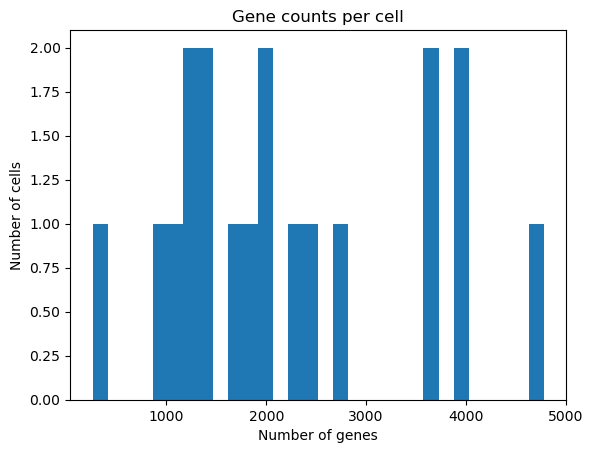

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Access the edge index for cell-gene expression relations
edge_index = train['cell', 'expr', 'gene'].edge_index

# Count gene occurrences per cell
cell_indices, gene_counts = np.unique(edge_index[0].numpy(), return_counts=True)

# Visualize the gene counts per cell using a histogram
plt.hist(gene_counts, bins=30)
plt.xlabel("Number of genes")
plt.ylabel("Number of cells")
plt.title("Gene counts per cell")
plt.show()

In [10]:
# train = train.to('cuda:0')
# test = test.to('cuda:0')
# val = val.to('cuda:0')

dataset = LightningDataset(
    train,
    test,
    val,
    num_neighbors=[25, 10], # The number of neighbors to be considered in each layer of the GNN to be considered by the sampler
    num_workers=4,
)

In [11]:
dataset

LightningDataset(train_dataset=HeteroData(
  cell={
    x=[19, 20138],
    y=[19]
  },
  gene={ x=[20138, 1] },
  (cell, expr, gene)={ edge_index=[2, 42380] }
), val_dataset=HeteroData(
  cell={
    x=[3, 20138],
    y=[3]
  },
  gene={ x=[20138, 1] },
  (cell, expr, gene)={ edge_index=[2, 7108] }
), test_dataset=HeteroData(
  cell={
    x=[2, 20138],
    y=[2]
  },
  gene={ x=[20138, 1] },
  (cell, expr, gene)={ edge_index=[2, 2126] }
), num_neighbors=[25, 10], num_workers=4, batch_size=1, pin_memory=True, persistent_workers=True)

## Training Model

In [15]:
class HGT(pl.LightningModule):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in ['cell', 'gene']:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, train.metadata(),
                           num_heads, group='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return self.lin(x_dict[target])

    def training_step(self, batch, batch_idx):
        x_dict, edge_index_dict, y = batch
        y_hat = self(x_dict, edge_index_dict)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x_dict, edge_index_dict, y = batch
        y_hat = self(x_dict, edge_index_dict)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        return {'val_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [16]:
# Instantiate the HeteroGNN model
hidden_channels = 32
node_types = train['cell'].y.unique()
target = 'cell'
out_channels = len(train['cell'].y.unique())
num_layers = 2
num_heads = 2
model = HGT(hidden_channels, out_channels, num_heads, num_layers)

# Create a PyTorch Lightning Trainer and train the model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, datamodule=dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes regis

ProcessRaisedException: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/torch/multiprocessing/spawn.py", line 69, in _wrap
    fn(i, *args)
  File "/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 147, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 559, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 893, in _run
    self.strategy.setup_environment()
  File "/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/pytorch_lightning/strategies/ddp.py", line 143, in setup_environment
    super().setup_environment()
  File "/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/pytorch_lightning/strategies/strategy.py", line 127, in setup_environment
    self.accelerator.setup_device(self.root_device)
  File "/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/pytorch_lightning/accelerators/cuda.py", line 43, in setup_device
    _check_cuda_matmul_precision(device)
  File "/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/lightning_fabric/accelerators/cuda.py", line 345, in _check_cuda_matmul_precision
    major, _ = torch.cuda.get_device_capability(device)
  File "/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/torch/cuda/__init__.py", line 381, in get_device_capability
    prop = get_device_properties(device)
  File "/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/torch/cuda/__init__.py", line 395, in get_device_properties
    _lazy_init()  # will define _get_device_properties
  File "/home/samuel.dsouza/.conda/envs/gnn/lib/python3.9/site-packages/torch/cuda/__init__.py", line 235, in _lazy_init
    raise RuntimeError(
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


In [ ]:
# Test the model
trainer.test(ckpt_path='best', datamodule=dataset)